# Install Package ke Venv Phyton

In [1]:
# !pip install xgboost

# Import Library

In [17]:
# Manipulasi Data
import pandas as pd

# File System dan Path
import os
from pathlib import Path

# Regex (Text Matching)
import re

# Machine Learning dan Feature Extraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# deteksi tipe file
import mimetypes

# menyimpan model
import pickle

# Import Dataframe

In [3]:
df = pd.read_csv("data_downloads_cleaned.csv")

In [4]:
df.columns

Index(['FileName', 'FileExt', 'DateModified', 'Size_KB', 'Size_GB', 'Source',
       'Path', 'SimplePath', 'ParentPath', 'FileNameClean', 'FileType', 'Year',
       'Month', 'UsiaDokumen', 'Size_MB', 'SizeCategory', 'Source_Class',
       'Path_modified', 'Folder_Root', 'Subfolder_L2', 'Subfolder_L3',
       'Subfolder_L4', 'Subfolder_L5', 'Subfolder_L6', 'Filename',
       'Path_Class', 'Path_Anomali', 'Path_Uniform'],
      dtype='object')

# Feature Exxtraction

In [5]:
df_ml = df.copy()

In [6]:
text_feature = 'FileNameClean'
categorical_features = ['FileExt', 'SimplePath']
numerical_feature = 'Size_KB'

# Encoding Kolom

## Encoding FileName dan Size_KB

Karena datanya 1D tidak ada baris ataupun value yang lebih dari satu maka bisa lgsg digunakan dengan ColumnTransformer

In [7]:
# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(max_features=300), 'FileNameClean'),
    ('scaler', StandardScaler(), ['Size_KB'])
], remainder='passthrough')  # Biarkan FileExt_encoded dan SimplePath_encoded tetap masuk

## Encoding Label pada FileExt dan SimplePath

In [8]:
le_fileext = LabelEncoder()
le_simplepath = LabelEncoder()

In [9]:
df_ml['FileExt_encoded'] = le_fileext.fit_transform(df_ml['FileExt'].astype(str))
df_ml['SimplePath_encoded'] = le_simplepath.fit_transform(df_ml['SimplePath'].astype(str))

In [10]:
# Gabungkan hasil pre-processing ke DataFrame baru
df_model = df_ml[[text_feature, 'FileExt_encoded', 'SimplePath_encoded', numerical_feature, 'FileType']].copy()

### Penyimpanan Label Encoder untuk Prediksi

In [11]:
import joblib

joblib.dump(le_fileext, 'models/label_encoder_fileext.pkl')
joblib.dump(le_simplepath, 'models/label_encoder_simplepath.pkl')

['models/label_encoder_simplepath.pkl']

# Splitting Data for Machine Learning

In [12]:
# Fitur dan target
X = df_model[[text_feature, 'FileExt_encoded', 'SimplePath_encoded', numerical_feature]]
y = df_model['FileType']

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pre-Modelling

In [14]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(max_features=300), text_feature),
    ('scaler', StandardScaler(), [numerical_feature]),
], remainder='passthrough')  # Passthrough: FileExt_encoded dan SimplePath_encoded

# Modelling

In [15]:
# Pipeline model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [16]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=300),
                                                  'FileNameClean'),
                                                 ('scaler', StandardScaler(),
                                                  ['Size_KB'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [18]:
# Prediksi pada data uji
y_pred = model_pipeline.predict(X_test)

# Evaluasi Model

In [19]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

     archive       1.00      0.85      0.92        13
       audio       1.00      0.80      0.89        10
         cad       1.00      0.71      0.83         7
        code       0.00      0.00      0.00         3
      config       1.00      1.00      1.00         3
        data       0.99      0.99      0.99       135
      design       1.00      0.80      0.89         5
    document       0.97      0.99      0.98       140
  geoscience       1.00      0.50      0.67         2
         gis       0.99      0.99      0.99       536
       image       0.99      0.98      0.98       210
    notebook       1.00      1.00      1.00         1
     package       0.96      1.00      0.98        43
presentation       0.00      0.00      0.00         3
     project       1.00      0.97      0.99        34
 spreadsheet       0.93      1.00      0.96        54
    subtitle       0.00      0.00      0.00         0
   

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\m

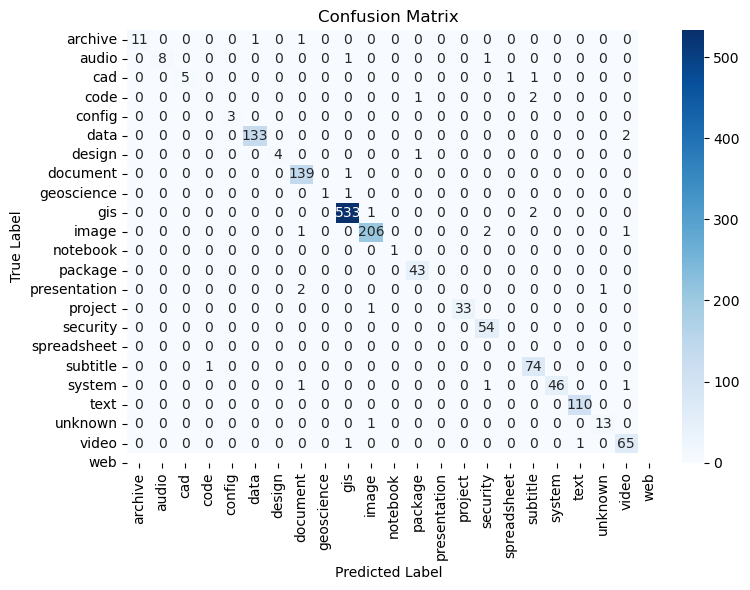

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_pipeline.classes_,
            yticklabels=model_pipeline.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [21]:
# Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {acc:.4f}")


Accuracy Score: 0.9789


# Input to New Dataframe from Model ML

In [22]:
# Buat DataFrame prediksi dan indeksnya disesuaikan dengan X_test
df_pred = X_test.copy()
df_pred['FileType_actual'] = y_test
df_pred['FileType_predicted'] = y_pred

In [23]:
# Gabungkan ke df_model (jika ingin semua prediksi termasuk training)
# Atau simpan hanya prediksi dari test set
df_model = df_ml[[text_feature, 'FileExt_encoded', 'SimplePath_encoded', numerical_feature, 'FileType']].copy()
df_model['FileType_predicted'] = model_pipeline.predict(df_model[[text_feature, 'FileExt_encoded', 'SimplePath_encoded', numerical_feature]])

In [26]:
df_model

,FileNameClean,FileExt_encoded,SimplePath_encoded,Size_KB,FileType,FileType_predicted
0,Desktop,54,5387,0.28,system,code
1,Googledrivesetup,34,365,331614.59,system,system
2,Cover Letter Graduate 2025 Mott Macdonald,82,182,74.41,document,document
3,Hcml Well Sample,131,366,275.54,spreadsheet,spreadsheet
4,Document Location Number List Final 01 Eko Aut...,131,221,1921.30,spreadsheet,spreadsheet
...,...,...,...,...,...,...
7563,7 Penggunaan Lahan,82,5005,2045.92,document,document
7564,4 Gunungapi,82,5002,1533.31,document,document
7565,1 Kelas Lereng,82,4999,2025.40,document,document
7566,5 Pengamatan,82,5003,1617.38,document,document


In [32]:
# (Opsional) Periksa hasil
df_model[['FileNameClean','FileType', 'FileType_predicted']].sample(5)

,FileNameClean,FileType,FileType_predicted
5579,Proposal Kp Ptallied Indo Coal Jaya Final,document,document
1972,Macros,system,system
4341,Agritanamcampur Ar 25Kshp,data,data
7292,Makam Ar 50K,gis,gis
2210,Ec Spanish,system,system


In [34]:
# Simpan ke CSV
df_model.to_csv("document-filetype_prediction_testset.csv", index=False)